In [ ]:
# We will use the official tokenization script created by the Google team
! pip install -q -U "tensorflow-text==2.11.*"
! pip install -q tf-models-official==2.11.0 #For optimizer

In [ ]:
! pip install transformers

## Loading Data

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import pandas as pd
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
from imblearn.over_sampling import RandomOverSampler


# import tokenization

In [ ]:
#loading data in pandas dataframe

data_train = pd.read_json('./data/train.jsonl', lines=True)
data_valid = pd.read_json('./data/dev.jsonl', lines=True)
data_test = pd.read_json('./data/test.jsonl', lines=True)

In [ ]:
data_train.head()

,text,label,label_text
0,"a stirring , funny and finally transporting re...",4,very positive
1,apparently reassembled from the cutting-room f...,1,negative
2,they presume their audience wo n't sit still f...,1,negative
3,the entire movie is filled with deja vu moments .,2,neutral
4,this is a visually stunning rumination on love...,3,positive


3    2322
1    2218
2    1624
4    1288
0    1092
Name: label, dtype: int64


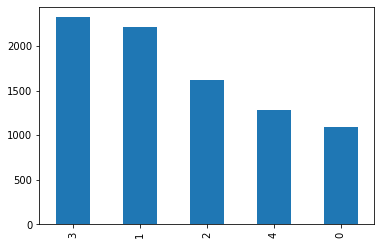

In [ ]:
data_train['label'].value_counts().plot(kind='bar')
print(data_train['label'].value_counts())

Preprocessing using Tokenizer

## Preprocessing

In [ ]:
tfhub_handle_preprocess = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"

In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [ ]:
text_test = ['this is such an amazing movie!']
print(data_train['text'][0])
text_preprocessed = bert_preprocess_model(text_test) #by default it truncates each vector at 128
print(text_preprocessed)
# print(text_preprocessed["input_word_ids"])
#Testing
print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

a stirring , funny and finally transporting re-imagining of beauty and the beast and 1930s horror films
{'input_mask': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
      dtype=int32)>, 'input_type_ids': <tf.Tensor: shape=(1, 128), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0,

In [ ]:
comments = data_train['text'].values
labels = data_train['label'].values


In [ ]:
# Use RandomOverSampler to balance the classes

# oversampler = RandomOverSampler(random_state=42)
# comments_resampled, labels_resampled = oversampler.fit_resample(comments.reshape(-1, 1), labels)

# # count the number of samples in each class after oversampling
# class_counts = pd.Series(labels_resampled).value_counts()
# print("Class counts after oversampling:\n", class_counts)


Class counts after oversampling:
 4    2322
1    2322
2    2322
3    2322
0    2322
dtype: int64


In [ ]:
# train_comments = []
# for comment in comments_resampled:
#   train_comments.append(comment[0])

In [ ]:
NUM_CLASSES = 5

#One hot encode since we have more than 2 classes
def one_hot_encode(dataset):
    num_samples = len(dataset)
    # labels = dataset['label']
    encoding = np.zeros((num_samples, NUM_CLASSES))
    
    for i in range(num_samples):
        label_value = dataset[i]
        encoding[i][label_value] = 1
        
    return encoding
    
y_train = one_hot_encode(data_train['label'])
y_valid = one_hot_encode(data_valid['label'])
y_test = one_hot_encode(data_test['label'])
y_train

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [ ]:
def preprocess(comments):
  return bert_preprocess_model(comments)

In [ ]:
train_dataset = preprocess(data_train['text'].tolist())
valid_train = preprocess(data_valid['text'].tolist())
test_train = preprocess(data_test['text'].tolist())

## Input Pipeline

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((train_dataset['input_word_ids'], train_dataset['input_mask'], train_dataset['input_type_ids'], y_train))
valid_ds = tf.data.Dataset.from_tensor_slices((valid_train['input_word_ids'], valid_train['input_mask'], valid_train['input_type_ids'], y_valid))
test_ds = tf.data.Dataset.from_tensor_slices((test_train['input_word_ids'], test_train['input_mask'], test_train['input_type_ids'], y_test))

In [ ]:
def map_features(input_word_ids, input_type_ids, input_mask,label):
    return ({"input_word_ids":input_word_ids, "input_type_ids":input_type_ids, 'input_mask': input_mask}, label) #(input, output) reformat


In [ ]:
#Input pipeline
def prepare_dataset(dataset, batch_size=64):
    dataset = dataset.map(map_features)
    dataset = dataset.shuffle(10000)
    dataset = dataset.batch(batch_size)
    return dataset

In [ ]:
train_ds = prepare_dataset(train_ds)
valid_ds = prepare_dataset(valid_ds)
test_ds = prepare_dataset(test_ds)
train_ds.take(1)

<TakeDataset element_spec=({'input_word_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(None, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Create Bert Model

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
# bert_layer = hub.KerasLayer(model_url)

# bert_results = bert_layer([text_preprocessed['input_ids'],text_preprocessed['input_masks']])

# print(f'Loaded BERT: {model_url}')
# print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
# print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
# print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
# print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

In [ ]:
def build_classifier_model(seq_length=128):
  input_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name='input_word_ids')
  input_mask = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name='input_mask')
  input_type_ids = tf.keras.layers.Input(shape=(seq_length,), dtype=tf.int32, name='input_type_ids')
  
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  embeddings = encoder({'input_word_ids': input_ids, 'input_mask': input_mask, 'input_type_ids': input_type_ids})['pooled_output']

  x = tf.keras.layers.Dense(128, activation='relu')(embeddings)
  x = tf.keras.layers.Dense(64, activation='relu')(x)

  y = tf.keras.layers.Dense(5, activation='softmax', name='classifier')(embeddings)

  return tf.keras.Model(inputs=[input_ids, input_mask, input_type_ids], outputs=y)


In [ ]:
classifier_model = build_classifier_model()

In [ ]:
classifier_model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_mask (InputLayer)        [(None, 128)]        0           []                               
                                                                                                  
 input_type_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 input_word_ids (InputLayer)    [(None, 128)]        0           []                               
                                                                                                  
 BERT_encoder (KerasLayer)      {'sequence_output':  28763649    ['input_mask[0][0]',             
                                 (None, 128, 512),                'input_type_ids[0][0]',   

### Train

In [ ]:
loss = tf.keras.losses.CategoricalCrossentropy(name='categorical_crossentropy')
metrics = tf.metrics.CategoricalAccuracy()

In [ ]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [168]:
print(f'Training model with {tfhub_handle_encoder}')
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)
earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

history = classifier_model.fit(x=train_ds,
                               validation_data=valid_ds,
                               epochs=epochs,
                               callbacks=[checkpoint, earlystopping],
                               batch_size=64,
                               verbose=1
                               )

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5
134/134 [==============================] - ETA: 0s - loss: 1.5911 - categorical_accuracy: 0.2707 

134/134 [==============================] - 2583s 19s/step - loss: 1.5911 - categorical_accuracy: 0.2707 - val_loss: 1.5649 - val_categorical_accuracy: 0.2598
Epoch 2/5
134/134 [==============================] - ETA: 0s - loss: 1.5396 - categorical_accuracy: 0.3010 

134/134 [==============================] - 2521s 19s/step - loss: 1.5396 - categorical_accuracy: 0.3010 - val_loss: 1.4383 - val_categorical_accuracy: 0.3542
Epoch 3/5
134/134 [==============================] - ETA: 0s - loss: 1.4369 - categorical_accuracy: 0.3654 

134/134 [==============================] - 2572s 19s/step - loss: 1.4369 - categorical_accuracy: 0.3654 - val_loss: 1.4108 - val_categorical_accuracy: 0.3724
Epoch 4/5
134/134 [==============================] - ETA: 0s - loss: 1.3881 - categorical_accuracy: 0.3914 

134/134 [==============================] - 2509s 19s/step - loss: 1.3881 - categorical_accuracy: 0.3914 - val_loss: 1.3629 - val_categorical_accuracy: 0.4105
Epoch 5/5
134/134 [==============================] - ETA: 0s - loss: 1.3540 - categorical_accuracy: 0.4109 

134/134 [==============================] - 2508s 19s/step - loss: 1.3540 - categorical_accuracy: 0.4109 - val_loss: 1.3518 - val_categorical_accuracy: 0.4024


In [171]:
classifier_model.save('sentiment_model')

In [172]:
loss, acc = classifier_model.evaluate(test_ds)


35/35 [==============================] - 191s 5s/step - loss: 1.3598 - categorical_accuracy: 0.4054
